In [1]:
from IPython.core.display import HTML

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from scipy.integrate import odeint, trapz, simps
from IPython.display import HTML

from scipy.fft import fft, ifft
matplotlib.rcParams.update({'font.size': 14})


# 1.a Pseudospectral method

based on the code in:´

https://www.youtube.com/watch?v=rsdqvrldgHM&list=WL&index=181

To do:

- check the pseudo spectral method, make another own implementation based on https://github.com/ketch/PseudoSpectralPython/blob/master/PSPython_02-pseudospectral-collocation.ipynb

- check my own implementation with the way that the professor explained
- opend dat file


In [3]:
def diffusion_q(q,t,w_x,nx,l):
    # pseudospectral differential equation
    
    # args-> q :array, the propagator to solve
    #        t: vector, represents the polymer contour 
    #       wx: array, the external field
    #       nx: scalar, number of x points
    #       l: scalar, length of the system
    
    # coeffient for the second derivative
    a = ((l/2.0)**2)/6
    # n that indexes the fourier modes
    n = np.fft.fftfreq(nx)*nx#*2*np.pi/l
    #N = len(q)
    #n = np.arange(N); n[int(N/2)+1:]-= N
    
    return a *ifft(((2*np.pi*1j*n/l)**2)*fft(q)).real - w_x*q

def diffusion_q_dagger(q,t,w_x,nx,l):
    # pseudospectral differential equation
    
    # args-> q :array, the propagator to solve
    #        t: vector, represents the polymer contour 
    #       wx: array, the external field
    #       nx: scalar, number of x points
    #       l: scalar, length of the system
    
    # coeffient for the second derivative
    a = ((l/2.0)**2)/6
    #n that indexes the fourier modes
    n = np.fft.fftfreq(nx)*nx#*2*np.pi/l
    #N = len(q)
    #n = np.arange(N); n[int(N/2)+1:]-= N

    return - a * ifft(((2*np.pi*1j*n/l)**2*fft(q))).real + w_x*q

def calculate_densities(re,x ,s, f ,wa, wb):
    # Calculates the densities of given wa and wb
    
    # args -> re: scalar, Re experimental paramaterer
    # x: aray, array with space position
    # s: array, position of chains
    # f: scalar, cut off point between A and B parts
    # wa: array, w field for the first half of the copolymer
    # wb: array, w field for the second half of the copolymer
    
    # returs-> phi_a, phi_b arrays representing the densities 
    
    # length of the system
    L = 2*re
    # number of space points
    nx = len(x)
    # number of beads
    n = len(s)
    
    # initial conditions
    q0 = q0_dag = np.ones(nx)
    
    # first half of the polymer start from the first bead
    q_1 = odeint(diffusion_q, q0, s[:int(n*f)], args=(wa,nx,L))
    # second half of the polymer 
    q_2 = odeint(diffusion_q, q_1[-1], s[int(n*f):], args=(wb,nx,L))
    q = np.concatenate((q_1,q_2),axis=0)

    # for the transposed q start from the last bead 
    qdag_1 = odeint(diffusion_q_dagger, q0_dag, np.flip(s[int(n*f):]), args=(wb,nx,L))
    qdag_2 = odeint(diffusion_q_dagger, qdag_1[-1], np.flip(s[:int(n*f)]), args=(wa,nx,L))
    q_dag = np.concatenate((qdag_1,qdag_2),axis=0)
    q_dag = np.flip(q_dag)
    
    return q, q_dag


In [4]:
# length of the system
Re = 1.0
L = 2*Re
# number of points in space 
Nx = 256
# number of beads in the polymer contour
N = 64
# spatial discretization 
x = np.linspace(0,Nx, Nx)
x[:Nx] = x[:Nx]*L/Nx
# periodic boundaries
x[-1] = x[0]

# polymer contour
s = np.linspace(0,1,N)
# cutting point of the polymer diving A and B
F = 1/2

# fields  used for the differential equation
wa = 5*np.cos(2*np.pi*x/L)
wb = -1*wa
q, q_dag = calculate_densities(Re,x,s, F ,wa, wb)

Calculate the single chain partition function to make sure that propagators are correct. This partition function should be constant across all 's'

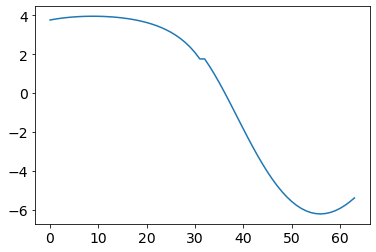

In [5]:
Q_Q0 = trapz(q*q_dag, x,axis=1)
plt.plot(Q_Q0)


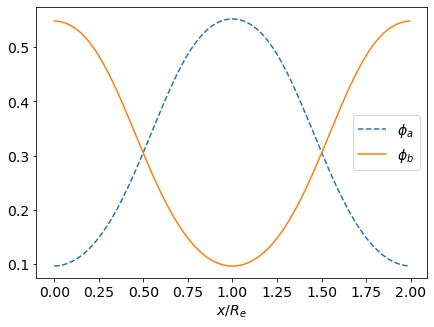

In [96]:
prod_q = q*q_dag
phi_a = (1/np.max(Q_Q0))*trapz(prod_q[:int(len(s)*F)], s[:int(len(s)*F)],axis=0)
phi_b = (1/np.max(Q_Q0))*trapz(prod_q[int(len(s)*F):], s[int(len(s)*F):],axis=0)

plt.figure(figsize=(7,5))
plt.plot(x[:-1], phi_a[:-1], label='$\phi_a$',linestyle='dashed')
plt.plot(x[:-1], phi_b[:-1],label='$\phi_b$')
plt.xlabel(r'$x/R_e$')
plt.legend()


Double check with simpy


from sympy.solvers.pde import pdsolve
from sympy import Function, Eq
from sympy.abc import x, y
from sympy import Heaviside

f = Function('f')
u = f(x, y)
ux = u.diff(x)
uxx = ux.diff(x)
uy = u.diff(y)
#eq = Eq(1 + (2*(ux/u)) + (3*(uy/u)), 0)
eq = Eq(uy, Re**2/6*uxx - Heaviside(x))
pdsolve(eq)

# 2b. Picard iteration and self consistent field theory

our starting point is the fields that we calculated earlier

We have to take care to iterate under one of our two conditions stops being valid:
   1. $\omega_{-} = -\chi^N [\phi_A - \phi_B]$ ---> Repulsion betwen A and B
   2. $1 = [\phi_A + \phi_B]$ ----> Incompresibility
   
At each step we check that there is not a deviation higher than 10^-6 at any point of the x grid

In [34]:
# define parameters and initial values
Chi_N = 15
Alpha = 0.1
# set up the variables to stop the loop
target_deviation = 10**(-1)
stop_loop = False


wa = 5*np.cos(2*np.pi*x/L)
wb = -wa

# initial values
w_minus_old = wa - wb
w_plus_old = wa + wb

phi_a_old = phi_a.copy()
phi_b_old = phi_b.copy()

consistency_1 = []
consistency_2 = []

phi_a_list = []
phi_b_list = []

deviation_1 = []
deviation_2 = []

Q0_list = []


In [35]:
i = 0
while(stop_loop==False):
    # update the omegas
    w_minus = Alpha*( Chi_N*( phi_b_old - phi_a_old ) - w_minus_old ) + w_minus_old
    w_plus = Alpha*( Chi_N*( phi_b_old + phi_a_old ) - 1 ) + w_plus_old

    # calculate the new fields
    wa_new = 0.5*(w_minus + w_plus)
    wb_new = - 0.5*(w_minus - w_plus)

    # calculate the new propagators and densities
    q, q_dag = calculate_densities(Re,x,s, F ,wa_new, wb_new)
    prod_q = q*q_dag

    Q_Q0 = trapz(prod_q, x,axis=1)

    phi_a_new = trapz(prod_q[:int(len(s)*F)], s[:int(len(s)*F)],axis=0)*(1/np.max(Q_Q0))*L
    phi_b_new = trapz(prod_q[int(len(s)*F):], s[int(len(s)*F):],axis=0)*(1/np.max(Q_Q0))*L
        
    # check that restrictions hold
    # first condition right hand side
    rhs_1 = Chi_N*(phi_a_new - phi_b_new)
    rhs_2 = phi_a_new + phi_b_new
    
    dev_1 = np.abs(w_minus_old + rhs_1)
    dev_2 = np.abs(np.abs(1 - rhs_2))
    
    # update values for the next iteration
    w_minus_old = wa_new - wb_new
    w_plus_old = wa_new + wb_new
    
    phi_a_old = phi_a_new
    phi_b_old = phi_b_new
    
    # save quantities of interest
    consistency_1.append(list(rhs_1))
    consistency_2.append(list(rhs_2))

    phi_a_list.append(list(phi_a_new))
    phi_b_list.append(list(phi_b_new))

    deviation_1.append(dev_1)
    deviation_2.append(dev_2)
    
    Q0_list.append(list(Q_Q0))
    
    # check whether the stop condition holds
    if((max(dev_1)< target_deviation) & (max(dev_2)< target_deviation)):
        # by comparing the maximum of dev_1 we make sure that the condition holds for every x
        stop = True
        
    # add this to show something while the loop runs
    i+=1  
    if(i%10==0):
        print("elapsed iterations: ", i)
        print("current max deviations:", (max(dev_1), max(dev_2)))

    
    

elapsed iterations:  10
current max deviations: (2.1706303688111728, 0.13555214971211704)
elapsed iterations:  20
current max deviations: (1.2013452417997499, 0.08392887984018715)
elapsed iterations:  30
current max deviations: (3.0309723371503914, 0.14067089977171376)
elapsed iterations:  40
current max deviations: (7.895146298252153, 0.7925915494560583)
elapsed iterations:  50
current max deviations: (2.0406129548450433, 1.5215804610017345)
elapsed iterations:  60
current max deviations: (2.36446211096023, 1.0423311170257823)
elapsed iterations:  70
current max deviations: (2.8232526129972655, 1.0601099808001049)
elapsed iterations:  80
current max deviations: (25.102803223815098, 3.1315530478064497)
elapsed iterations:  90
current max deviations: (5.953475186172568, 1.0461650759110965)
elapsed iterations:  100
current max deviations: (12.886537916325178, 0.909471381338179)
elapsed iterations:  110
current max deviations: (320.5735696073476, 46.61973865429087)
elapsed iterations:  12

/Users/rasputin/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


KeyboardInterrupt: 

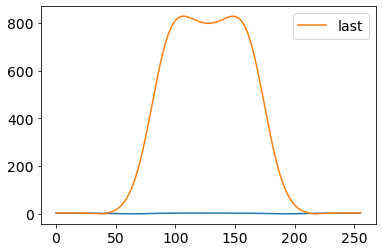

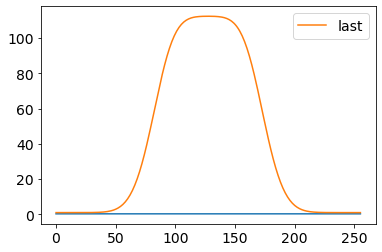

In [36]:
plt.figure()
plt.plot(deviation_1[0])
plt.plot(deviation_1[-1], label='last')
plt.legend()

plt.figure()
plt.plot(deviation_2[0])
plt.plot(deviation_2[-1], label='last')
plt.legend()


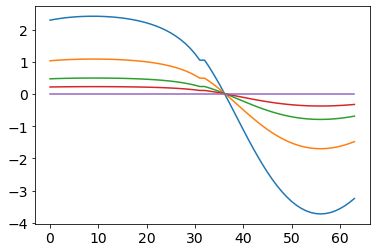

In [40]:
plt.plot(Q0_list[0])
plt.plot(Q0_list[1])
plt.plot(Q0_list[2])
plt.plot(Q0_list[3])
plt.plot(Q0_list[-1])



# Explicit euler method 

 


In [4]:
def diffusion_q(q,t,w_x,nx,l):
    # pseudospectral differential equation
    
    # args-> q :array, the propagator to solve
    #        t: vector, represents the polymer contour 
    #       wx: array, the external field
    #       nx: scalar, number of x points
    #       l: scalar, length of the system
    
    # coeffient for the second derivative
    a = ((l/2.0)**2)/6
    # n that indexes the fourier modes
    n = np.fft.fftfreq(nx)#*nx#*2*np.pi/l
    
    return a *ifft(((2*np.pi*1j*n/l)**2)*fft(q)).real - w_x*q

def diffusion_q_dagger(q,t,w_x,nx,l):
    # pseudospectral differential equation
    
    # args-> q :array, the propagator to solve
    #        t: vector, represents the polymer contour 
    #       wx: array, the external field
    #       nx: scalar, number of x points
    #       l: scalar, length of the system
    
    # coeffient for the second derivative
    a = ((l/2.0)**2)/6
    # n that indexes the fourier modes
    n = np.fft.fftfreq(nx)#*nx#*2*np.pi/l

    return - a * ifft(((2*np.pi*1j*n/l)**2*fft(q))).real + w_x*q


In [6]:
def spectral_q(q,t,wx,nx,l):
    # pseudospectral differential equation
    
    # args-> q :array, the propagator to solve
    #        t: vector, represents the polymer contour 
    #       wx: array, the external field
    #       nx: scalar, number of x points
    #       l: scalar, length of the system
    
    # coeffient for the second derivative
    a = ((l/2.0)**2)/6
    # n that indexes the fourier modes
    n = np.fft.fftfreq(nx)*2*np.pi*1.j/l
    ds = t[1]-t[0]
    return np.exp(-1*wx*ds/2.0)* ifft( np.exp(a*n**2*ds)*fft(np.exp(-wx*ds/2.0*q))).real

def spectral_q_dag(q,t,wx,nx,l):
    # pseudospectral differential equation
    
    # args-> q :array, the propagator to solve
    #        t: vector, represents the polymer contour 
    #       wx: array, the external field
    #       nx: scalar, number of x points
    #       l: scalar, length of the system
    
    # coeffient for the second derivative
    a = ((l/2.0)**2)/6
    # n that indexes the fourier modes
    n = np.fft.fftfreq(nx)*2*np.pi*1.j/l
    ds = t[0]-t[1]
    return (np.exp(wx*ds/2.0)* ifft( np.exp(-a*n**2*ds)*fft(np.exp(wx*ds/2.0*q))).real)

# re,x ,s, f ,wa, wb
def calculate_densities(s,nx,f,L, wa, wb):
    q = [np.ones(Nx)]
    q_dag = [np.ones(Nx)]
    
    # for q
    w_curr = wa
    for i in range(0,len(s)-1):
        if i==int(len(s)*f):
            w_curr = wb

        q_next = spectral_q(q[i],s,w_curr,nx,L)
        q.append(list(q_next))
    q = np.asarray(q)

    w_curr = wb
    # for dag
    for i in range(0,len(s)-1):
        if i==int(len(s)*f):
            w_curr = wa

        q_dag_next = spectral_q_dag(q_dag[i],s,w_curr,nx,L)
        q_dag.append(list(q_dag_next))
    q_dag = np.flip(q_dag)
    
    return q, q_dag




In [7]:
# length of the system
Re = 1.0
L = 2*Re
# number of points in space 
Nx = 256
# number of beads in the polymer contour
N = 64
# spatial discretization 
x = np.linspace(0,Nx, Nx)
x[:Nx] = x[:Nx]*L/Nx
# periodic boundaries
x[-1] = x[0]

# polymer contour
s = np.linspace(0,1,N)
# cutting point of the polymer diving A and B
F = 1/2

wa = 5*np.cos(2*np.pi*x/L)
wb = -wa

In [8]:
q,q_dag = calculate_densities(s,Nx,F,L, wa, wb)   

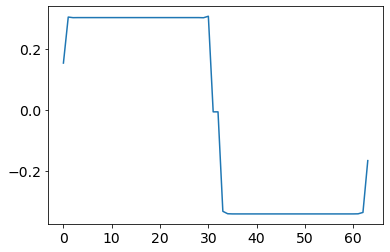

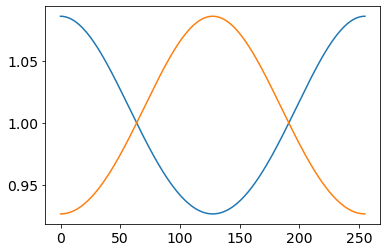

In [9]:
Q_Q0 = trapz(q*q_dag, x,axis=1)
plt.plot(Q_Q0)
plt.figure()
plt.plot(q[-1])
plt.plot(q_dag[0])



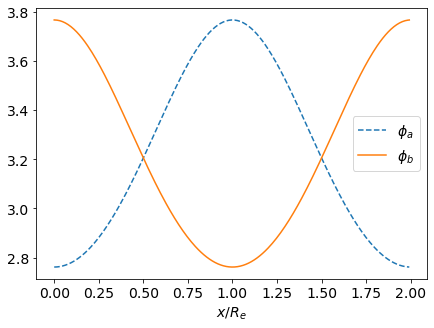

In [11]:
prod_q = q*q_dag
phi_a = (L/np.max(Q_Q0))*trapz(prod_q[:int(len(s)*F)], s[:int(len(s)*F)],axis=0)
phi_b = (L/np.max(Q_Q0))*trapz(prod_q[int(len(s)*F):], s[int(len(s)*F):],axis=0)

plt.figure(figsize=(7,5))
plt.plot(x[:-1], phi_a[:-1], label='$\phi_a$',linestyle='dashed')
plt.plot(x[:-1], phi_b[:-1],label='$\phi_b$')
plt.xlabel(r'$x/R_e$')
plt.legend()



In [22]:
# define parameters and initial values
Chi_N = 15
Alpha = 0.1
# set up the variables to stop the loop
target_deviation = 10**(-6)

wa = 5*np.cos(2*np.pi*x/L)
wb = -wa

# initial values
w_minus_old = wa - wb
w_plus_old = wa + wb

phi_a_old = phi_a.copy()
phi_b_old = phi_b.copy()

consistency_1 = []
consistency_2 = []

phi_a_list = []
phi_b_list = []

deviation_1 = []
deviation_2 = []

Q0_list = []
w_minus_list = []


In [23]:
stop_loop = False

i = 0
while(stop_loop==False):
    # update the omegas
    w_minus = Alpha*( Chi_N*( phi_b_old - phi_a_old ) - w_minus_old ) + w_minus_old
    w_plus = Alpha*( Chi_N*( phi_b_old + phi_a_old ) - 1 ) + w_plus_old

    # calculate the new fields
    wa_new = 0.5*(w_minus + w_plus)
    wb_new = - 0.5*(w_minus - w_plus)

    # calculate the new propagators and densities
    # (s,Nx,F,L, wa, wb) 
    q, q_dag = calculate_densities(s,Nx,F,L,wa_new, wb_new)
    prod_q = q*q_dag

    Q_Q0 = trapz(prod_q, x,axis=1)

    phi_a_new = trapz(prod_q[:int(len(s)*F)], s[:int(len(s)*F)],axis=0)*(L/np.max(Q_Q0))
    phi_b_new = trapz(prod_q[int(len(s)*F):], s[int(len(s)*F):],axis=0)*(L/np.max(Q_Q0))
        
    # check that restrictions hold
    # first condition right hand side
    rhs_1 = Chi_N*(phi_a_new - phi_b_new)
    rhs_2 = phi_a_new + phi_b_new
    
    dev_1 = np.abs(w_minus_old + rhs_1)
    dev_2 = np.abs(np.abs(1 - rhs_2))
    
    # save quantities of interest
    consistency_1.append(list(rhs_1))
    consistency_2.append(list(rhs_2))

    phi_a_list.append(list(phi_a_new))
    phi_b_list.append(list(phi_b_new))

    deviation_1.append((dev_1))
    deviation_2.append(list(dev_2))
    
    Q0_list.append(list(Q_Q0))
    
    w_minus_list.append(list(w_minus))
    
    # update values for the next iteration
    w_minus_old = wa_new - wb_new
    w_plus_old = wa_new + wb_new
    
    phi_a_old = phi_a_new
    phi_b_old = phi_b_new
    
    
    # check whether the stop condition holds
    if((max(dev_1)< target_deviation) or (max(dev_2)< target_deviation)):
        # by comparing the maximum of dev_1 we make sure that the condition holds for every x
        stop_loop = True
        
    # add this to show something while the loop runs
    i+=1  
    if(i%50==0):
        print("elapsed iterations: ", i)
        print("current max deviations:", (max(dev_1), max(dev_2)))

elapsed iterations:  50
current max deviations: (1.7646455164440278, 5.711713681106862)
elapsed iterations:  100
current max deviations: (0.32625975969279875, 7.302695049423715)
elapsed iterations:  150
current max deviations: (0.036515221742028814, 13.436608080610931)
elapsed iterations:  200
current max deviations: (0.0008682079056772096, 15.740840910246142)
elapsed iterations:  250
current max deviations: (9.564515416116137e-06, 15.799371391780646)


Text(0.5, 0, '$x/R_e$')

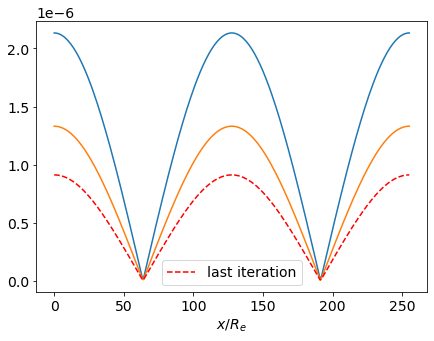

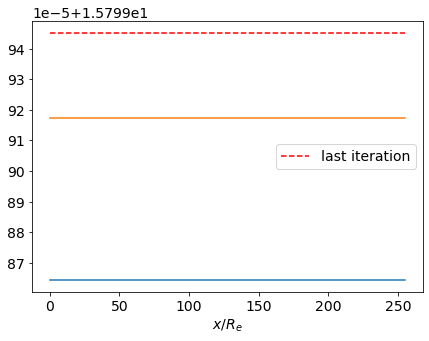

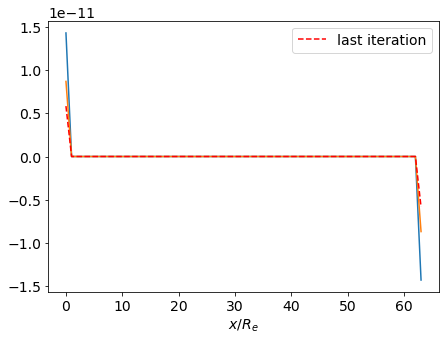

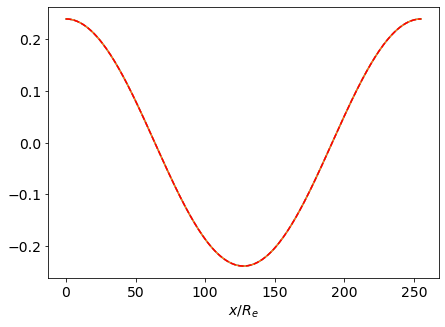

In [41]:
plt.figure(figsize=(7,5))
#plt.plot(deviation_1[0])
plt.plot(deviation_1[-10])
plt.plot(deviation_1[-5])
plt.plot(deviation_1[-1], linestyle='dashed' ,color='r',label='last iteration')
plt.xlabel(r'$x/R_e$')
plt.legend()

plt.figure(figsize=(7,5))
plt.plot(deviation_2[-10])
plt.plot(deviation_2[-5])
plt.plot(deviation_2[-1], linestyle='dashed' ,color='r',label='last iteration')
plt.xlabel(r'$x/R_e$')
plt.legend()


plt.figure(figsize=(7,5))
plt.plot(Q0_list[-10])
plt.plot(Q0_list[-5])
plt.plot(Q0_list[-1], linestyle='dashed' ,color='r',label='last iteration')
plt.xlabel(r'$x/R_e$')
plt.legend()

plt.figure(figsize=(7,5))
plt.plot(w_minus_list[-10])
plt.plot(w_minus_list[-5])
plt.plot(w_minus_list[-1], linestyle='dashed' ,color='r',label='last iteration')
plt.xlabel(r'$x/R_e$')





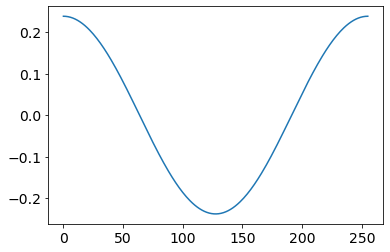